In [1]:
import gpflow
import tensorflow as tf
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
plt.style.use('ggplot')
%matplotlib inline

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

import keras
from keras.datasets import mnist
from keras import backend as K
 


xs_train_full = np.genfromtxt("../data/mnist_train_features.csv", delimiter=",")
xs_test_full = np.genfromtxt("../data/mnist_test_features.csv", delimiter=",")

def get_mnist_classes():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, 10)
    y_test = keras.utils.to_categorical(y_test, 10)
    return ((x_train, x_test), (y_train, y_test))

((mnist_train_full, mnist_test_full), (ys_train_full, ys_test_full)) = get_mnist_classes()


Using TensorFlow backend.


In [2]:
# fitting entirety of model on base MNIST data

num_features = xs_train_full.shape[-1]
num_classes = 10
print("Using", num_features, "features, predicting", num_classes, "classes")

ys = np.argmax(ys_train_full, axis=1)

gp_model = gpflow.models.SVGP(
    xs_train_full, ys, kern=gpflow.kernels.Matern32(input_dim=num_features) + gpflow.kernels.White(input_dim=num_features, variance=0.1),
    likelihood=gpflow.likelihoods.MultiClass(num_classes),
    Z=xs_train_full[::20].copy(), 
    num_latent=num_classes, 
    whiten=True, 
    q_diag=True,
    minibatch_size=8000)
gp_model.kern.white.variance.trainable = False
#gp_model.feature.trainable = False

Using 128 features, predicting 10 classes


In [3]:
opt = gpflow.train.ScipyOptimizer()
opt.minimize(gp_model)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 6100.389939
  Number of iterations: 18
  Number of functions evaluations: 34


In [4]:
(mu, var) = gp_model.predict_y(xs_test_full)
gp_predicted_classes = np.argmax(mu, axis=1)

In [5]:
correct_classes = np.argmax(ys_test_full, axis=1)

In [6]:
print("Num GP incorrect: ", np.count_nonzero(gp_predicted_classes != correct_classes))

Num GP incorrect:  92


In [7]:
img_rows, img_cols = 28, 28
if K.image_data_format() == 'channels_first':
    mnist_test_full_reshape = mnist_test_full.reshape(xs_test_full.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    mnist_test_full_reshape = mnist_test_full.reshape(xs_test_full.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    

mnist_test_full_reshape = mnist_test_full_reshape.astype('float32')
mnist_test_full_reshape /= 255

In [9]:
K.get_session().close() # just to be sure

# Keras approach!

# release graph resources when done otherwise inconsistent results
with tf.Graph().as_default():
    with tf.Session().as_default() as sess:
        K.set_session(sess)
        mnist_cnn = keras.models.load_model('../models/mnist_cnn.h5')
        cnn_test_probs = mnist_cnn.predict_on_batch(mnist_test_full_reshape)
        cnn_predicted_classes = np.argmax(cnn_test_probs, axis=1)
        print("Num CNN incorrect:", np.count_nonzero(cnn_predicted_classes != correct_classes))
        K.get_session().close()
  

Num CNN incorrect: 89


In [10]:
# TF approach!

with tf.Graph().as_default():
    with tf.Session() as sess:
        K.set_learning_phase(0) #set learning phase to test!
        # get the full CNN
        mnist_cnn = keras.models.load_model('../models/mnist_cnn.h5')
        
        x = tf.placeholder(tf.float32, shape=(None, 28, 28, 1))
        cnn_preds_placeholder = mnist_cnn(x)

        cnn_test_probs = cnn_preds_placeholder.eval(feed_dict={x: mnist_test_full_reshape})
        
        cnn_predicted_classes = np.argmax(cnn_test_probs, axis=1)
        print("Num CNN incorrect:", np.count_nonzero(cnn_predicted_classes != correct_classes))
        sess.close()

Num CNN incorrect: 89


In [11]:
# Combined model

"""
params:
    cnn_path: trained mnist CNN file path
    gp: trained gaussian process for multiclass classification
    verbose: printing on/off 
    accept_cnn_stddev: if CNN predicted class has higher prob than GP's, this is number of stddevs the CNN prediction needs to be within from the GP prediction to acccept it
        ie. higher = more likely to revert to CNN!
"""
def combined_predict(cnn_path, gp, images, verbose=False, accept_cnn_stddev=1):
    # so my CNN can only predict on batches of 4 or greater...
    if images.shape[0] < 4:
        print("Can only predict with >= 4 images at a time")
        return
    batch = images
    
    cnn_probs_batch = None
    features = None
    
    with tf.Graph().as_default():
        with tf.Session().as_default():
            mnist_cnn = keras.models.load_model(cnn_path)
            cnn_probs_batch = mnist_cnn.predict_on_batch(mnist_test_full_reshape)
    
            # need to get output of second to last layer in CNN to feed into GP

            if verbose:
                print("Extracting features from second to last layer of CNN")
            feature_extractor = K.function([mnist_cnn.layers[0].input, K.learning_phase()],
                                           [mnist_cnn.layers[-2].output])
            features = feature_extractor([images, 0])[0]
    
    gp_mu, gp_var = gp.predict_y(features)

    
    decisions = []
    decision_probs = []
    decision_vars = []
    for (mu, var, cnn_probs) in zip(gp_mu, gp_var, cnn_probs_batch):
        cnn_class = np.argmax(cnn_probs)
        gp_class = np.argmax(mu)
        
        gp_pred_prob = mu[gp_class]
        gp_pred_var = var[gp_class]
        
        cnn_pred_prob = cnn_probs[cnn_class]
        
        # both classes agree
        if gp_class == cnn_class:
            # we may have to accept the wrong decision but can't do anything about it
            #if verbose:
            #    print("Models agree on predicted class")
            decisions.append([0, gp_class, gp_pred_prob, gp_pred_var])
            decision_probs.append(mu)
            decision_vars.append(var)

        else:
            # disagreement! This is additional information
            # From prior experiments we suspect that NN is more likely to be correct [non-adverserial examples tested]
            # So, if we take the CNN prediction and check if it's the same as the _second_ highest GP prediction
            # try using that?

            # Revised:
            #  Take the CNN prediction IF it's probability is within 1 stddev of the corresponding GP class probability

            # core idea: if CNN is _too_ sure then we revert to GP prediction -- might be adverserial...?

            gp_prob_for_cnn_pred = mu[cnn_class]
            gp_stddev_for_cnn_pred = np.sqrt(var[cnn_class])

            if verbose:
                print("Models disagree on predicted class")

            if cnn_pred_prob < (gp_prob_for_cnn_pred + accept_cnn_stddev*gp_stddev_for_cnn_pred):
                if verbose:
                    print("  Taking CNN prediction, probability is within", accept_cnn_stddev, "stddev of GP probability")
                decisions.append([1, cnn_class, cnn_pred_prob, -1])
                decision_probs.append(cnn_probs)
                decision_vars.append([-1 for x in range(mu.shape[-1])])

            else:
                if verbose:
                    print("  Taking GP prediction")
                decisions.append([0, gp_class, gp_pred_prob, gp_pred_var])
                decision_probs.append(mu)
                decision_vars.append(var)
    return (np.array(decisions), np.array(decision_probs), np.array(decision_vars))


In [12]:
combined_pred, combined_mus, combined_vars = combined_predict(cnn_path="../models/mnist_cnn.h5", gp=gp_model, images=mnist_test_full_reshape, accept_cnn_stddev=1.0)
combined_pred_classes = combined_pred[:, 1]
combined_incorrect = combined_pred_classes != correct_classes
print("Num Combined incorrect: ", np.count_nonzero(combined_incorrect))

Num Combined incorrect:  90


In [13]:
# have all 3 models available now


In [28]:
from cleverhans.utils_mnist import data_mnist
from cleverhans.utils_tf import model_train, model_eval
from cleverhans.attacks import FastGradientMethod
from cleverhans.utils import AccuracyReport
from cleverhans.utils_keras import cnn_model
from cleverhans.utils_keras import KerasModelWrapper


adv_predictions = None
perturbed = None
with tf.Graph().as_default() as graph:
    with tf.Session().as_default() as sess:
        K.set_learning_phase(0) #set learning phase

        #make a fresh copy to not modify other graph
        model = keras.models.load_model('../models/mnist_cnn.h5')
            
        x = tf.placeholder(tf.float32, shape=(None, 28, 28, 1))
        y = tf.placeholder(tf.float32, shape=(None, 10))

        # Initialize the Fast Gradient Sign Method (FGSM) attack object and graph
        wrap = KerasModelWrapper(model)
        fgsm = FastGradientMethod(wrap, sess=sess)
        fgsm_params = {'eps': 0.10,
                       'clip_min': 0.,
                       'clip_max': 1.}
        adv_x = fgsm.generate(x, **fgsm_params)
        # Consider the attack to be constant
        adv_x = tf.stop_gradient(adv_x)
        preds_adv = model(adv_x)

        adv_predictions = sess.run(preds_adv, {x: mnist_test_full_reshape})
        perturbed = sess.run(adv_x, {x: mnist_test_full_reshape})
        


(10000, 28, 28, 1)
Incorrect:  809


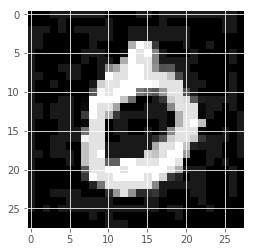

In [29]:

print(perturbed.shape)
plt.imshow(perturbed[3].reshape((28,28)), cmap=plt.get_cmap('gray'))
print("Incorrect: ", np.count_nonzero(correct_classes != np.argmax(adv_predictions, axis=1)))


In [30]:
def preprocess_mnist(xs, ys, one_hot_encode=-1):
    img_rows, img_cols = 28, 28    
    # reshape to inputs to correct shape
    if K.image_data_format() == 'channels_first':
        xs = xs.reshape(xs.shape[0], 1, img_rows, img_cols)
        input_shape = (1, img_rows, img_cols)
    else:
        xs = xs.reshape(xs.shape[0], img_rows, img_cols, 1)
        input_shape = (img_rows, img_cols, 1)
    xs = xs.astype('float32')
    xs /= 255
    
    if one_hot_encode != -1:
        ys = keras.utils.to_categorical(ys, one_hot_encode) # one_hot_encode is the number of classes
    
    return (xs, ys)


In [31]:
adv_fsgm_features = None
with tf.Graph().as_default():
    with tf.Session().as_default() as sess:
        K.set_session(sess)
        K.set_learning_phase(0) #set learning phase

        #make a fresh copy to not modify other graph
        model = keras.models.load_model('../models/mnist_cnn.h5')
        feature_extractor = K.function([model.layers[0].input, K.learning_phase()],
                                       [model.layers[6].output])
        pert, ys = preprocess_mnist(perturbed, ys_test_full)
        adv_fsgm_features = feature_extractor([pert])[0]

In [32]:
adv_fsgm_features

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [39]:
with gpflow.session_manager.get_session().as_default():
    (adv_mu, adv_var) = gp_model.predict_y(adv_fsgm_features)
    adv_gp_preds = np.argmax(adv_mu, axis=1)
    print("GP fsgm adversarial incorrect: ", np.count_nonzero(correct_classes != adv_gp_preds))


GP fsgm adversarial incorrect:  8865


tensorflow.python.client.session.Session

In [34]:
adv_combined_pred, adv_combined_mus, adv_combined_vars = combined_predict(cnn_path="../models/mnist_cnn.h5", gp=gp_model, images=perturbed, accept_cnn_stddev=0.5)
adv_combined_pred_classes = adv_combined_pred[:, 1]
adv_combined_incorrect = adv_combined_pred_classes != correct_classes
print("Num Combined incorrect: ", np.count_nonzero(adv_combined_incorrect))

Num Combined incorrect:  802
